#### 
https://github.com/gerolaleticia/Pyrentena-a-dataset-per-week/blob/master/Semana%203%20%20-%20Dataset%20CO2/Pyrentena%20semana%203%20-%20CO2.ipynb

Machine Learning model for CO2 emisssion

In [122]:
#!pip3 install mysql-connector     

import mysql.connector as sql
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error,mean_absolute_error
from sklearn.model_selection import train_test_split
import numpy as np

db_connection = sql.connect(host='10.0.0.21', database='co2_dev', user='co2user', password='c1m4V.21')
db_cursor = db_connection.cursor()
#db_cursor.execute('select id, ppm1, ppm2, date  from datos where ppm2 <= 10 and ppm1 < 300') #ppm1 > 340 and ppm1 < 395') #order by id desc limit 100000;
db_cursor.execute("select id, ppm1, ppm2, date  from datos where ppm2 <= 10 and ppm1 > 10 and ppm1 < 3000 and date >= '2022-01-01'")
table_rows = db_cursor.fetchall()

df = pd.DataFrame(table_rows, columns=['id', 'ppm', 'sensor', 'date_time'])

df

,id,ppm,sensor,date_time
0,1575986,324,3,2022-01-01 00:00:05
1,1575987,295,8,2022-01-01 00:00:07
2,1575988,351,10,2022-01-01 00:00:14
3,1575989,325,3,2022-01-01 00:00:15
4,1575990,326,3,2022-01-01 00:00:25
...,...,...,...,...
1315819,2892631,351,9,2022-04-19 16:47:55
1315820,2892632,261,8,2022-04-19 16:47:58
1315821,2892633,405,10,2022-04-19 16:48:03
1315822,2892634,510,5,2022-04-19 16:48:07


In [123]:
df.describe().applymap('{:,.2f}'.format) #.apply("{0:.5f}".format)

,id,ppm,sensor
count,"1,315,824.00","1,315,824.00","1,315,824.00"
mean,"2,234,101.98",404.47,7.50
std,"380,073.50",151.58,2.09
min,"1,575,986.00",72.00,3.00
25%,"1,904,991.75",359.00,5.00
50%,"2,233,949.50",375.00,8.00
75%,"2,562,940.25",398.00,9.00
max,"2,892,635.00","2,827.00",10.00


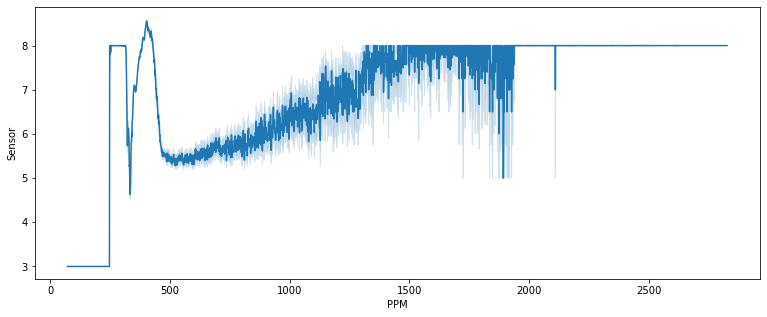

CPU times: user 51.6 s, sys: 394 ms, total: 52 s
Wall time: 52.7 s


In [124]:
%%time
plt.figure(figsize=(13,5)) 
sns.lineplot(x=df['ppm'], y=df['sensor']) 
plt.xlabel('PPM') 
plt.ylabel('Sensor') 
plt.show()

In [125]:
r = pd.DataFrame([df['sensor'] == 10])

In [126]:
r.shape

(1, 1315824)

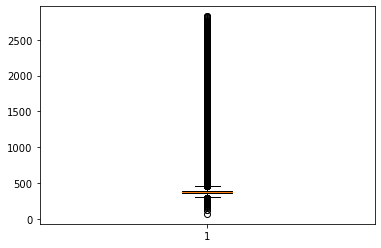

In [127]:
plt.boxplot(df[['ppm']])
plt.show()

In [128]:
plt.figure(figsize=(13,5))
corr = df[['sensor','ppm']].corr()
corr

,sensor,ppm
sensor,1.000000,-0.098399
ppm,-0.098399,1.000000


<Figure size 936x360 with 0 Axes>

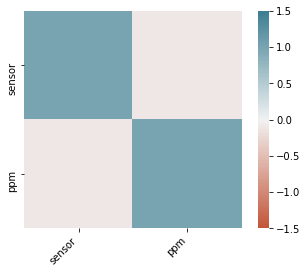

In [129]:
ax = sns.heatmap(corr, vmin=-1.5, vmax=1.5, center=0, cmap=sns.diverging_palette(20, 220, n=200),square=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right');

In [130]:
# features into variables
sensores = df[['sensor']]
ppms = df[['ppm']]

In [131]:
# spliting data in train and test with train_test_split
sensor_treino, sensor_test, ppm_treino, ppm_test = train_test_split(sensores, ppms, test_size=0.2, random_state=42)

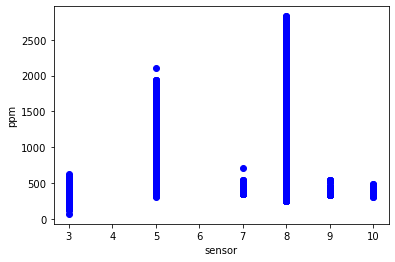

In [132]:
# ploting the correlation between features
plt.scatter(sensor_treino, ppm_treino, color='blue')
plt.xlabel('sensor')
plt.ylabel('ppm')
plt.show()

#### Creating the model with the train dataset

In [133]:
# creating a linear regression model
# LinearRegression is a method of sklearn
modelo = linear_model.LinearRegression()

In [134]:
# linear regression formula: (Y = A + B.X)
# training the model to obtain the values of A and B (always do it in the train dataset)
modelo.fit(sensor_treino, ppm_treino)

LinearRegression()

In [135]:
# exibiting the coeficients A and B that the model generated
print(f'(A) intercept: {modelo.intercept_} | (B) inclination: {modelo.coef_}')

(A) intercept: [457.98379378] | (B) inclination: [[-7.13147229]]


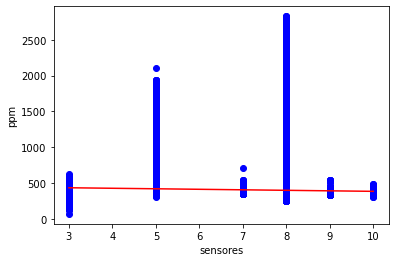

In [136]:
# print linear regression line on our TRAIN dataset
plt.scatter(sensor_treino, ppm_treino, color='blue')
plt.plot(sensor_treino, modelo.coef_[0][0]*sensor_treino + modelo.intercept_[0], '-r') 
# LR formula: inclination(B) * engine_treino(X) + intercept(A)
plt.ylabel('ppm')
plt.xlabel('sensores')
plt.show()

In [137]:
modelo.intercept_

array([457.98379378])

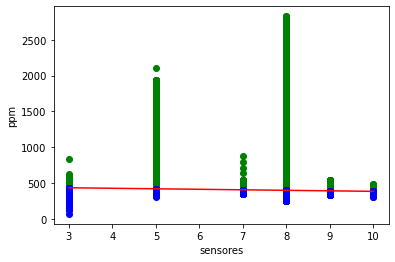

In [138]:
superior = df[df['ppm'] >  modelo.coef_[0][0]*df['sensor'] + modelo.intercept_[0]]
inferior = df[df['ppm'] < modelo.coef_[0][0]*df['sensor'] + modelo.intercept_[0]]

plt.scatter(superior['sensor'], superior['ppm'] , color='green')
plt.scatter(inferior['sensor'], inferior['ppm'] , color='blue')
plt.plot(sensor_treino, modelo.coef_[0][0]*sensor_treino + modelo.intercept_[0], '-r') 
# LR formula: inclination(B) * engine_treino(X) + intercept(A)
plt.ylabel('ppm')
plt.xlabel('sensores')
plt.show()

In [119]:
df['ppm'] > df['ppm'] + modelo.intercept_[0]

0         False
1         False
2         False
3         False
4         False
          ...  
641175    False
641176    False
641177    False
641178    False
641179    False
Name: ppm, Length: 641180, dtype: bool

#### Executing the model on the test dataset

In [120]:
predictCO2 = modelo.predict(sensor_test)

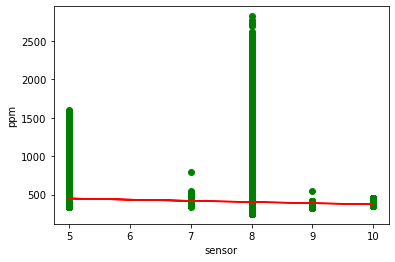

In [121]:
# print linear regression line on our TEST dataset
plt.scatter(sensor_test, ppm_test, color='green')
plt.plot(sensor_test, modelo.coef_[0][0]*sensor_test + modelo.intercept_[0], '-r')
plt.ylabel('ppm')
plt.xlabel('sensor')
plt.show()

#### Evaluating the model

In [138]:
# Showing metrics to check the acuracy of our model
print(f'Sum of squared error (SSE): {np.sum((predictCO2 - ppm_test)**2)}') # SSE: sum all of the  residuals and square them. 
print(f'Mean squared error (MSE): {mean_squared_error(ppm_test, predictCO2)}') # MSE: avg of SSE
print(f'Mean absolute error (MAE): {mean_absolute_error(ppm_test, predictCO2)}')
print (f'Sqrt of mean squared error (RMSE):  {np.sqrt(mean_squared_error(ppm_test, predictCO2))}') # RMSE: sqrt of the MSE
print(f'R2-score: {r2_score(predictCO2, ppm_test)}') # r2-score: explains the variance of the variable Y when it comes to X

Sum of squared error (SSE): ppm   11712932215.390
dtype: float64
Mean squared error (MSE): 20270.65577653844
Mean absolute error (MAE): 59.33094312463419
Sqrt of mean squared error (RMSE):  142.37505320995822
R2-score: -180.32001331192336
